# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Jaya Jaya Maju

- Nama: Jasmine Kinasih
- Email: jasminekinasih10@gmail.com
- Id Dicoding:jasmine_kinasih

## Import Library

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Data Loading & Understanding

In [2]:
dataset = "https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/refs/heads/main/employee/employee_data.csv"
df = pd.read_csv(dataset)

In [3]:
df.head()

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,NaN,Travel_Frequently,1444,Human Resources,1,4,Other,1,...,2,80,1,7,2,3,6,2,1,2
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
4,5,40,NaN,Travel_Rarely,1194,Research & Development,2,4,Medical,1,...,2,80,3,20,2,3,5,3,0,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  JobLevel

### Missing Value

In [5]:
#cek missing value
df.isnull().sum()

,0
EmployeeId,0
Age,0
Attrition,412
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0


Insight:
Terdapat missing values pada kolom Attrition sebanyak 412 baris. Untuk menangani hal tersebut, kita akan asumsikan pegawai dengan attrition yang hilang merupakan pegawai yang tetap bertahan di perusahaan sehingga kita dapat mengisinya dengan nilai 0. Berikut merupakan kode untuk menangani missing values tersebut.

In [6]:
df['Attrition'] = df['Attrition'].fillna(df['Attrition'].mode()[0])

### Duplicate

In [7]:
duplicate = df.duplicated().sum()
print("Jumlah data duplikat:", duplicate)

Jumlah data duplikat: 0


In [8]:
df['Attrition'] = df['Attrition'].astype(int)

In [9]:
df.to_csv('employee.csv', index=False)

Menyimpan data karyawaan untuk ditampilkan di metabase

### Outlier

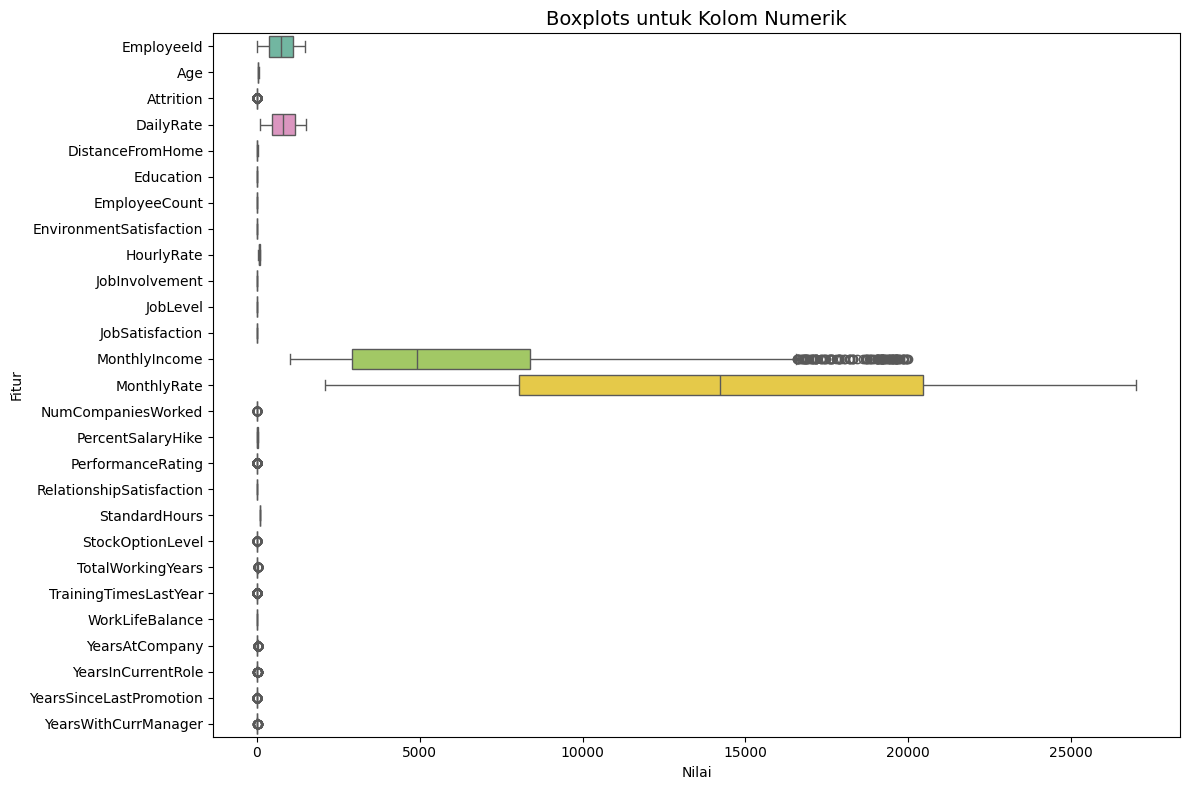

In [10]:
# Pastikan hanya kolom numerik yang diambil
numeric_cols = df.select_dtypes(include=np.number)

plt.figure(figsize=(12, 8))
sns.boxplot(data=numeric_cols, orient='h', palette='Set2')
plt.title("Boxplots untuk Kolom Numerik", fontsize=14)
plt.xlabel("Nilai")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

In [11]:
categorical_cols = df.select_dtypes(include=['object', 'category'])
print("Kolom kategorikal:")
print(categorical_cols.columns.tolist())

Kolom kategorikal:
['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


In [12]:
import pandas as pd
from scipy.stats import chi2_contingency

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if 'Attrition' in categorical_cols:
    categorical_cols.remove('Attrition')

print("Chi-square test results:\n")
significant_features = []

for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Attrition'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{col}: p-value = {p:.4f}")

    if p < 0.05:
        significant_features.append(col)

print("\nFitur kategorikal yang berpengaruh signifikan terhadap Attrition:")
print(significant_features)

Chi-square test results:

BusinessTravel: p-value = 0.0008
Department: p-value = 0.1190
EducationField: p-value = 0.0465
Gender: p-value = 0.9870
JobRole: p-value = 0.0000
MaritalStatus: p-value = 0.0000
Over18: p-value = 1.0000
OverTime: p-value = 0.0000

Fitur kategorikal yang berpengaruh signifikan terhadap Attrition:
['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']


In [13]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['EmployeeId'])
print("Kolom Numerik:")
print(numerical_cols.columns.tolist())

Kolom Numerik:
['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


### Mencari feature yang berkorelasi dengan `Attrition`

<ipython-input-14-130dd3da5045>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target_signed.values, y=corr_target_signed.index, palette='coolwarm', legend=False)


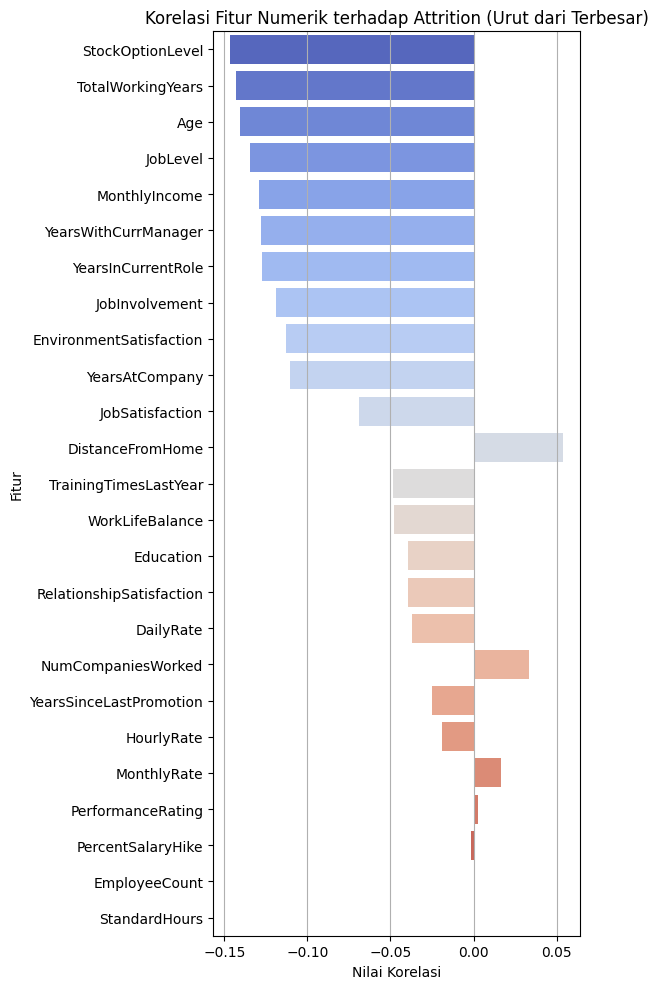

In [14]:
corr = numerical_cols.corr()

corr_target = corr['Attrition'].drop('Attrition')

corr_target_sorted = corr_target.abs().sort_values(ascending=False)
corr_target_signed = corr_target.loc[corr_target_sorted.index]

plt.figure(figsize=(6, 10))
sns.barplot(x=corr_target_signed.values, y=corr_target_signed.index, palette='coolwarm', legend=False)
plt.title('Korelasi Fitur Numerik terhadap Attrition (Urut dari Terbesar)')
plt.xlabel('Nilai Korelasi')
plt.ylabel('Fitur')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Insight:
Kolom yang memiliki korelasi paling signifikan terhadap Attrition (positif atau negatif) adalah:

🔻 Korelasi Negatif (semakin tinggi nilai, semakin kecil kemungkinan keluar):
* StockOptionLevel
* TotalWorkingYears
* Age
* JobLevel
* MonthlyIncome
* YearsWithCurrManager
* YearsInCurrentRole
* JobInvolvement
* EnvironmentSatisfaction
* YearsAtCompany
* JobSatisfaction

🔺 Korelasi Positif (semakin tinggi nilai, semakin besar kemungkinan keluar):
* NumCompaniesWorked
* YearsSinceLastPromotion

In [15]:
important_categorical = ['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']

important_numerical = [
    'MonthlyIncome',
    'TotalWorkingYears',
    'YearsAtCompany',
    'YearsWithCurrManager',
    'Age',
    'JobSatisfaction',
    'EnvironmentSatisfaction',
    'NumCompaniesWorked',
    'YearsSinceLastPromotion'
]

selected_features_df = df[important_categorical + important_numerical + ['Attrition']]

NOTE:
important_numerical adalah karena mereka menunjukkan korelasi paling signifikan (positif atau negatif) dengan Attrition. Memilih kolom-kolom ini memungkinkan analisis berfokus pada faktor-faktor paling berpengaruh yang dapat meningkatkan atau menurunkan attrition, sehingga memberikan insight yang paling relevan dan actionable.

In [16]:
important_categorical = ['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']

for col in important_categorical:
    print(f"\n📊 Kolom: {col}")
    print(df[col].value_counts())


📊 Kolom: BusinessTravel
BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: count, dtype: int64

📊 Kolom: EducationField
EducationField
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: count, dtype: int64

📊 Kolom: JobRole
JobRole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: count, dtype: int64

📊 Kolom: MaritalStatus
MaritalStatus
Married     673
Single      470
Divorced    327
Name: count, dtype: int64

📊 Kolom: OverTime
OverTime
No     1054
Yes     416
Name: count, dtype: int64


In [17]:
attrition_counts = df['Attrition'].value_counts()
attrition_counts

,count
Attrition,
0,1291
1,179


In [18]:
attrition_percentage = df['Attrition'].value_counts(normalize=True) * 100
attrition_percentage

,proportion
Attrition,
0,87.823129
1,12.176871


## Exploratory Data Analysis (EDA)

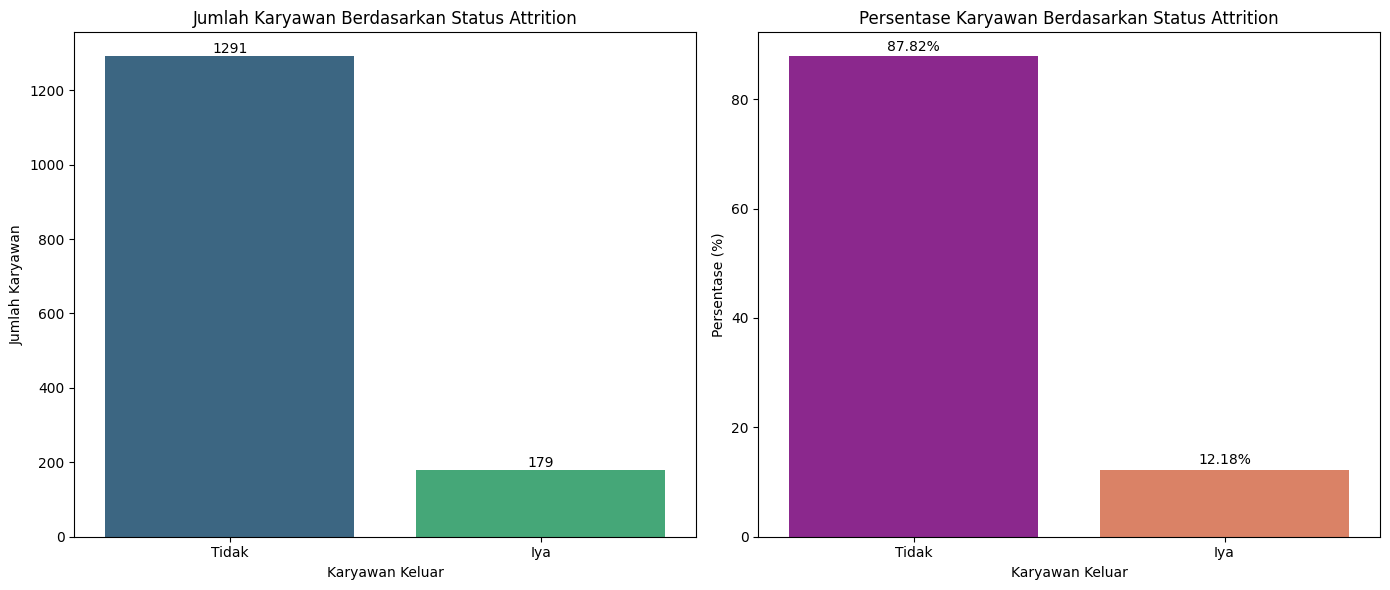

In [19]:
labels = {0: 'Tidak', 1: 'Iya'}
attrition_counts_labeled = attrition_counts.rename(index=labels)
attrition_percentage_labeled = attrition_percentage.rename(index=labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=attrition_counts_labeled.index, y=attrition_counts_labeled.values,
            hue=attrition_counts_labeled.index, ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Jumlah Karyawan Berdasarkan Status Attrition')
axes[0].set_xlabel('Karyawan Keluar')
axes[0].set_ylabel('Jumlah Karyawan')

for index, value in enumerate(attrition_counts_labeled.values):
    axes[0].text(index, value + 0.1, str(value), ha='center', va='bottom')


sns.barplot(x=attrition_percentage_labeled.index, y=attrition_percentage_labeled.values,
            hue=attrition_percentage_labeled.index, ax=axes[1], palette='plasma', legend=False)
axes[1].set_title('Persentase Karyawan Berdasarkan Status Attrition')
axes[1].set_xlabel('Karyawan Keluar')
axes[1].set_ylabel('Persentase (%)')

for index, value in enumerate(attrition_percentage_labeled.values):
    axes[1].text(index, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Insight:
Distribusi Target (Attrition)
- Tidak Keluar: 87.82%
- Keluar: 12.18%

Artinya, sebagian besar karyawan tidak keluar, tetapi Attrition tetap signifikan pada **12.18%** karyawan.

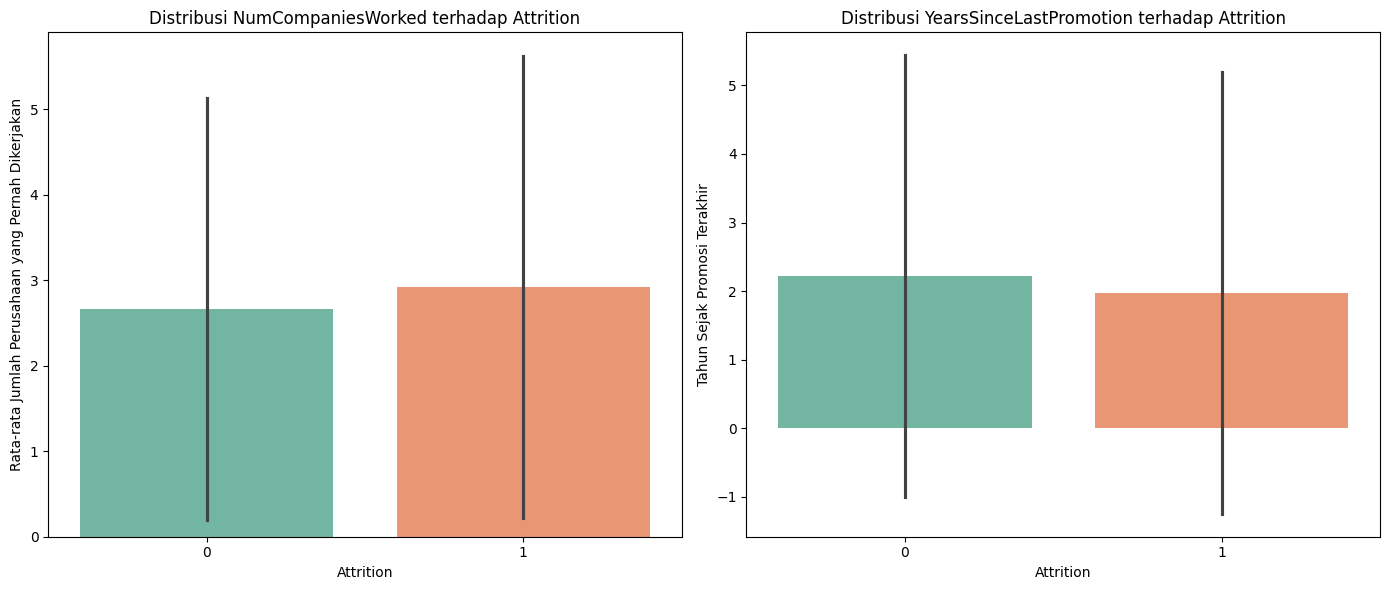

In [20]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=df, x='Attrition', y='NumCompaniesWorked', errorbar='sd', palette='Set2', hue='Attrition', legend=False)
plt.title('Distribusi NumCompaniesWorked terhadap Attrition')
plt.xlabel('Attrition')
plt.ylabel('Rata-rata Jumlah Perusahaan yang Pernah Dikerjakan')

plt.subplot(1, 2, 2)
sns.barplot(data=df, x='Attrition', y='YearsSinceLastPromotion', errorbar='sd', palette='Set2', hue='Attrition', legend=False)
plt.title('Distribusi YearsSinceLastPromotion terhadap Attrition')
plt.xlabel('Attrition')
plt.ylabel('Tahun Sejak Promosi Terakhir')

plt.tight_layout()
plt.show()

Insight:
* Ada sedikit kecenderungan bahwa karyawan yang lebih sering berpindah-pindah perusahaan sebelumnya (memiliki riwayat bekerja di lebih banyak perusahaan) cenderung lebih mungkin untuk keluar

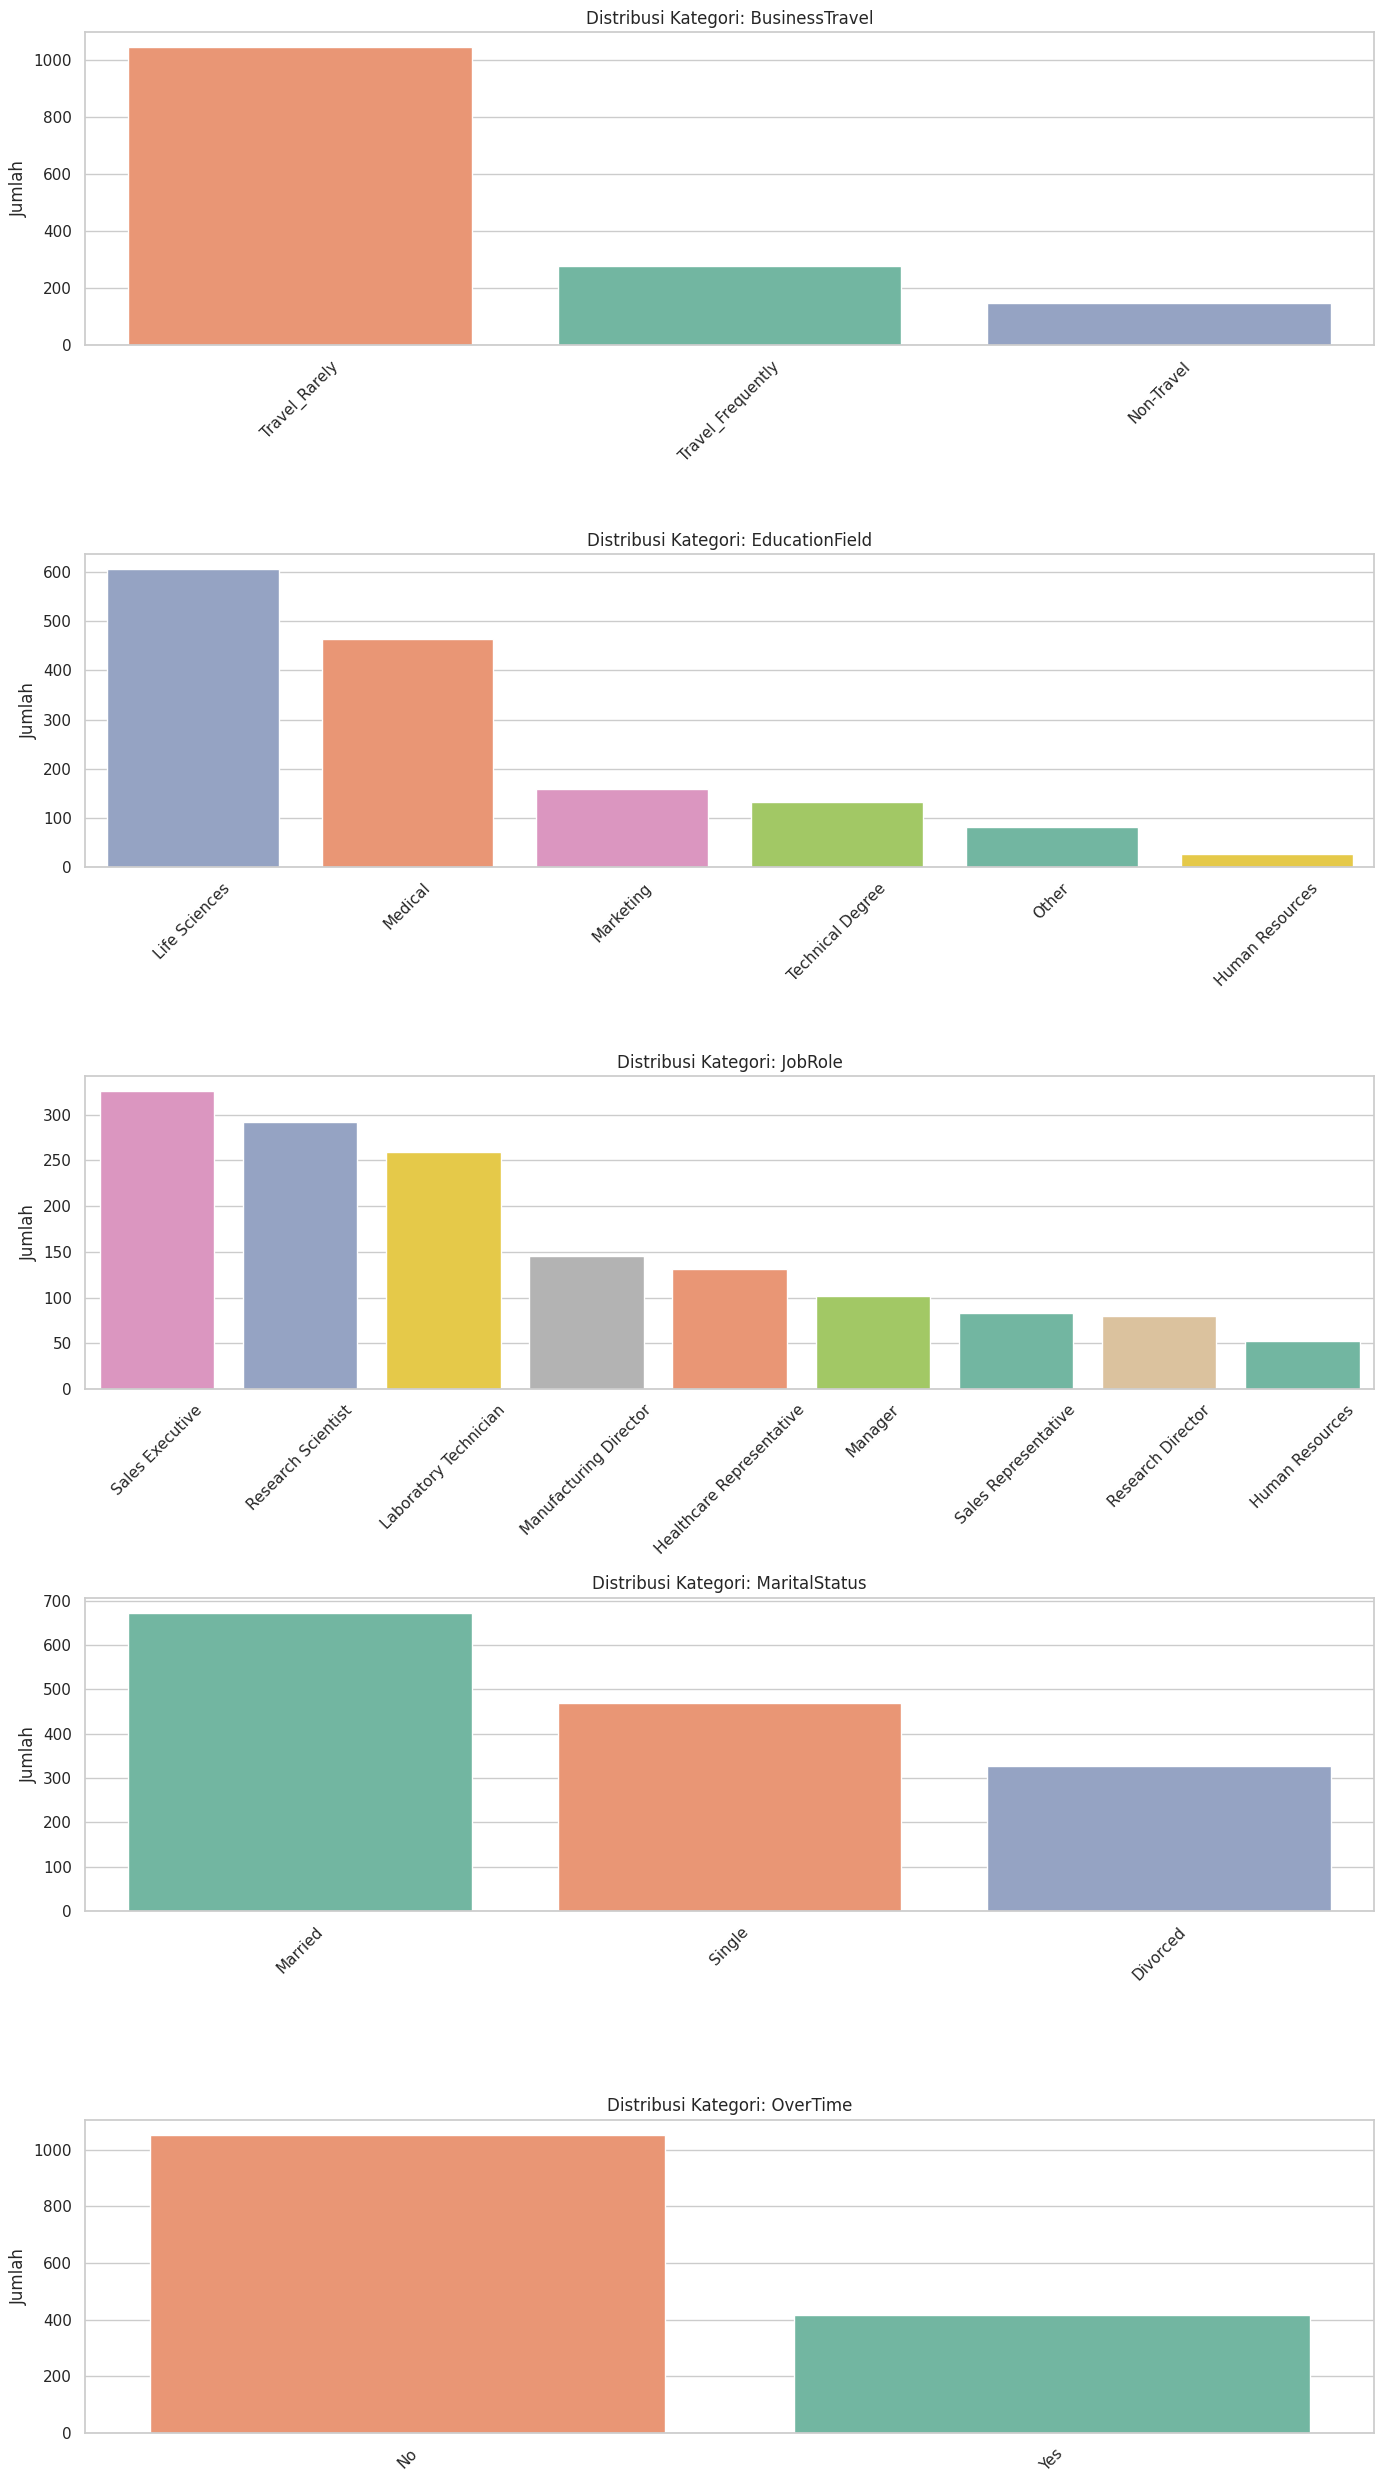

In [21]:
important_categorical = ['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']

sns.set(style="whitegrid")
plt.figure(figsize=(14, 5 * len(important_categorical)))

for i, col in enumerate(important_categorical, 1):
    plt.subplot(len(important_categorical), 1, i)
    sns.countplot(data=df, x=col, palette='Set2', order=df[col].value_counts().index,
                  hue=df[col], legend=False)
    plt.title(f'Distribusi Kategori: {col}')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

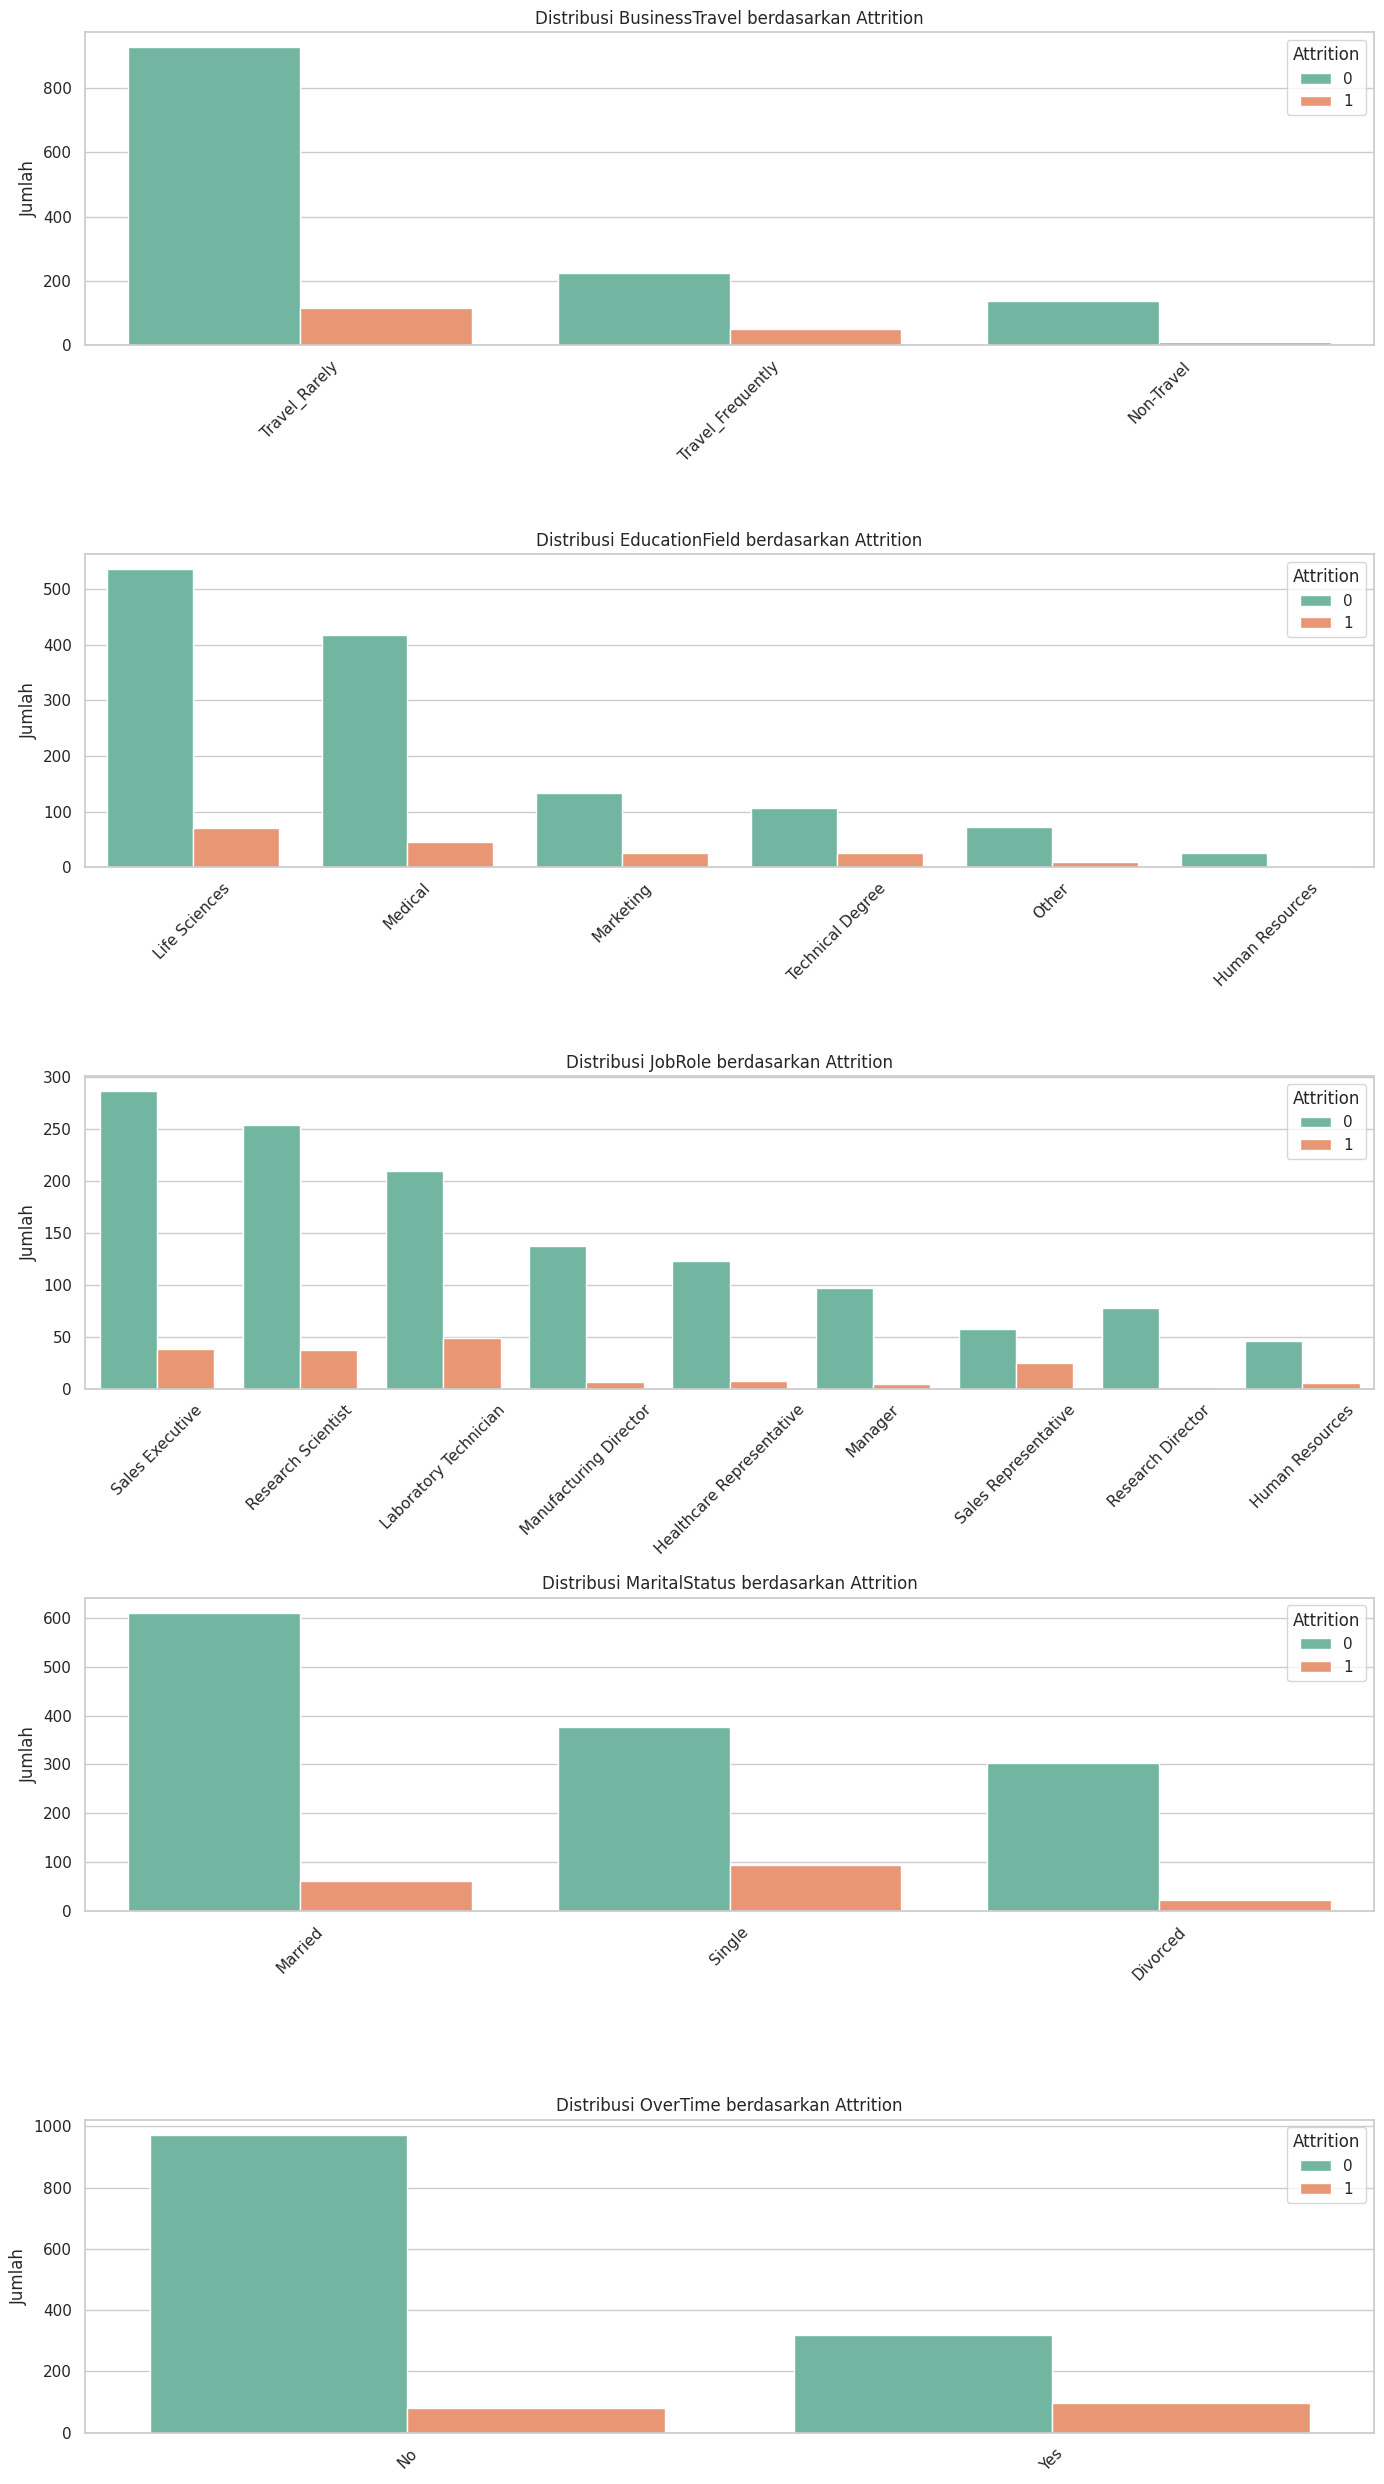

In [22]:
important_categorical = ['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']

sns.set(style="whitegrid")
plt.figure(figsize=(14, 5 * len(important_categorical)))

for i, col in enumerate(important_categorical, 1):
    plt.subplot(len(important_categorical), 1, i)
    sns.countplot(data=df, x=col, hue='Attrition', palette='Set2', order=df[col].value_counts().index)
    plt.title(f'Distribusi {col} berdasarkan Attrition')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

Insight:
Faktor-faktor kategorikal yang paling signifikan memengaruhi attrition di Jaya Jaya Maju adalah:
* Lembur (OverTime = Yes): Ini adalah pendorong attrition paling menonjol.
* Status Pernikahan (Single): Karyawan lajang lebih rentan.
* Peran Jabatan (Sales Representative, Sales Executive, Laboratory Technician): Beberapa peran memiliki risiko attrition yang lebih tinggi.
* Perjalanan Bisnis (Travel Frequently): Perjalanan yang sering berdampak negatif pada retensi.
* Bidang Pendidikan (Technical Degree): Karyawan dari bidang ini mungkin memiliki pilihan pasar yang lebih luas.

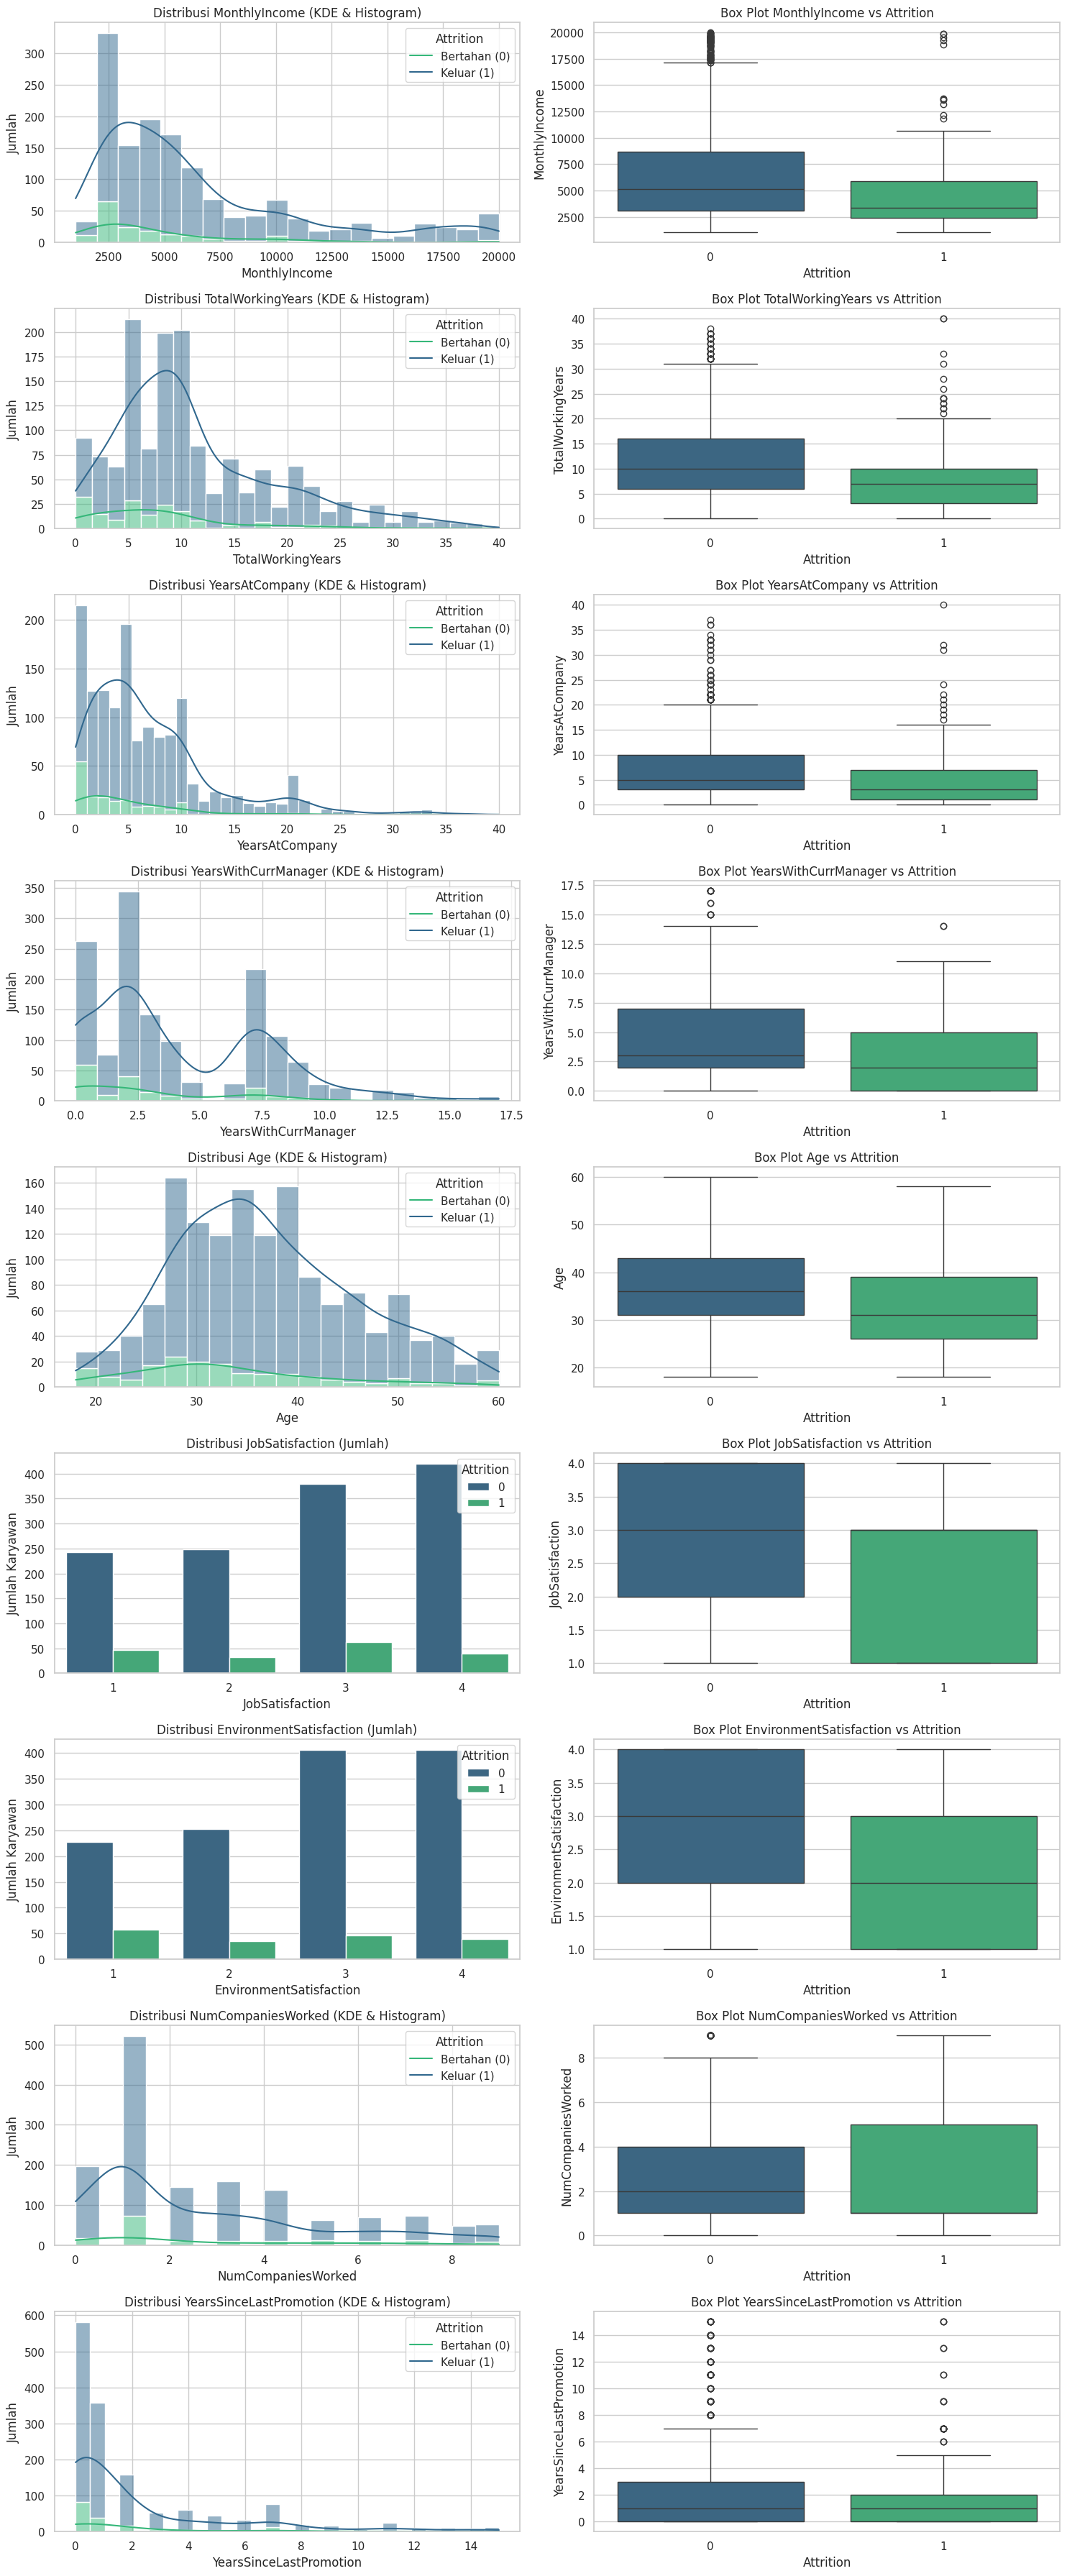

In [23]:
important_numerical = [
    'MonthlyIncome',
    'TotalWorkingYears',
    'YearsAtCompany',
    'YearsWithCurrManager',
    'Age',
    'JobSatisfaction',
    'EnvironmentSatisfaction',
    'NumCompaniesWorked',
    'YearsSinceLastPromotion'
]

plt.figure(figsize=(15, 4 * len(important_numerical)))

for i, col in enumerate(important_numerical):
    plt.subplot(len(important_numerical), 2, 2*i + 1)
    if col in ['JobSatisfaction', 'EnvironmentSatisfaction']:
        sns.countplot(data=df, x=col, hue='Attrition', palette='viridis')
        plt.title(f'Distribusi {col} (Jumlah)')
        plt.xlabel(col)
        plt.ylabel('Jumlah Karyawan')
        plt.legend(title='Attrition', loc='upper right')
    else:
        sns.histplot(data=df, x=col, hue='Attrition', kde=True, multiple='stack', palette='viridis')
        plt.title(f'Distribusi {col} (KDE & Histogram)')
        plt.xlabel(col)
        plt.ylabel('Jumlah')
        plt.legend(title='Attrition', labels=['Bertahan (0)', 'Keluar (1)'])

    plt.subplot(len(important_numerical), 2, 2*i + 2)
    sns.boxplot(data=df, x='Attrition', y=col, palette='viridis', hue='Attrition', legend=False)
    plt.title(f'Box Plot {col} vs Attrition')
    plt.xlabel('Attrition')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

Dari semua visualisasi ini, beberapa poin kunci muncul sebagai pendorong utama attrition di Jaya Jaya Maju:

1. Kompensasi (Gaji Bulanan) dan Tingkat Jabatan: Karyawan dengan gaji lebih rendah dan level jabatan lebih rendah memiliki risiko attrition yang jauh lebih tinggi.
2. Usia & Pengalaman: Karyawan yang lebih muda dan kurang berpengalaman (baik total tahun kerja maupun tahun di perusahaan) cenderung lebih mungkin untuk keluar.
3. Stabilitas Internal: Durasi yang singkat di perusahaan dan durasi yang singkat dengan manajer saat ini sangat terkait dengan attrition.
4. Kepuasan: Kepuasan kerja dan kepuasan lingkungan yang rendah secara signifikan meningkatkan kemungkinan attrition.
5. Riwayat Pekerjaan: Karyawan dengan riwayat sering berpindah perusahaan di masa lalu cenderung lebih mungkin untuk keluar.
6. Manajemen Promosi: Hubungannya kompleks, tetapi kurangnya promosi dalam beberapa tahun atau bahkan promosi yang tidak memenuhi ekspektasi (setelah promosi 0 tahun) dapat mendorong attrition.

## Data Preparation / Preprocessing

### Encoding dan Scaling fitur

In [24]:
selected_features = important_categorical + important_numerical + ['Attrition']
df_selected = df[selected_features].copy()

X = df_selected.drop(columns='Attrition')
y = df_selected['Attrition']

X_encoded = pd.get_dummies(X, columns=important_categorical, drop_first=True)

scaler = StandardScaler()
X_encoded[important_numerical] = scaler.fit_transform(X_encoded[important_numerical])

In [25]:
joblib.dump(X_encoded.columns.tolist(), "encoded_columns.pkl")

['encoded_columns.pkl']

### Menyelesaikan Oversampling

In [27]:
from sklearn.utils import shuffle

X_minority = X_encoded[y == 1]
y_minority = y[y == 1]

X_majority = X_encoded[y == 0]
y_majority = y[y == 0]

n_majority = len(y_majority)
n_minority = len(y_minority)
n_to_add = n_majority - n_minority

X_minority_oversampled = X_minority.sample(n=n_to_add, replace=True, random_state=42)
y_minority_oversampled = y_minority.sample(n=n_to_add, replace=True, random_state=42)

X_balanced = pd.concat([X_majority, X_minority, X_minority_oversampled], axis=0)
y_balanced = pd.concat([y_majority, y_minority, y_minority_oversampled], axis=0)

X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

### Split data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print("Distribusi kelas train setelah oversampling dan split:")
print(y_train.value_counts())
print("\nDistribusi kelas test setelah oversampling dan split:")
print(y_test.value_counts())

Distribusi kelas train setelah oversampling dan split:
Attrition
1    1033
0    1032
Name: count, dtype: int64

Distribusi kelas test setelah oversampling dan split:
Attrition
0    259
1    258
Name: count, dtype: int64


## Modeling

Model yang digunakan yaitu:
1. Logistic Regression
2. Random Forest
3. XgBoost

### Hyperparameter tuning model dan training

In [29]:
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear']
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7]
    })
}

best_models = {}

## Evaluation


Training dan tuning untuk LogisticRegression...
Best params LogisticRegression: {'C': 0.1, 'solver': 'liblinear'}
Classification report LogisticRegression:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       259
           1       0.76      0.80      0.78       258

    accuracy                           0.78       517
   macro avg       0.78      0.78      0.78       517
weighted avg       0.78      0.78      0.78       517



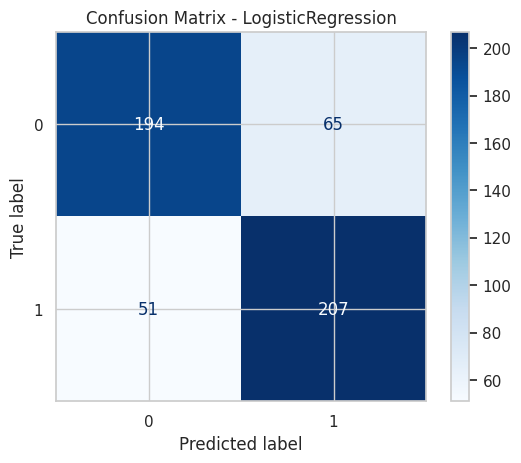


Training dan tuning untuk RandomForest...
Best params RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Classification report RandomForest:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       259
           1       0.95      1.00      0.98       258

    accuracy                           0.97       517
   macro avg       0.98      0.97      0.97       517
weighted avg       0.98      0.97      0.97       517



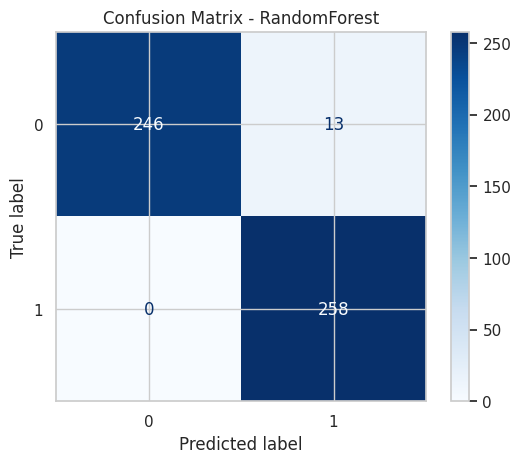


Training dan tuning untuk XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:58:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Classification report XGBoost:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       259
           1       0.91      1.00      0.95       258

    accuracy                           0.95       517
   macro avg       0.95      0.95      0.95       517
weighted avg       0.95      0.95      0.95       517



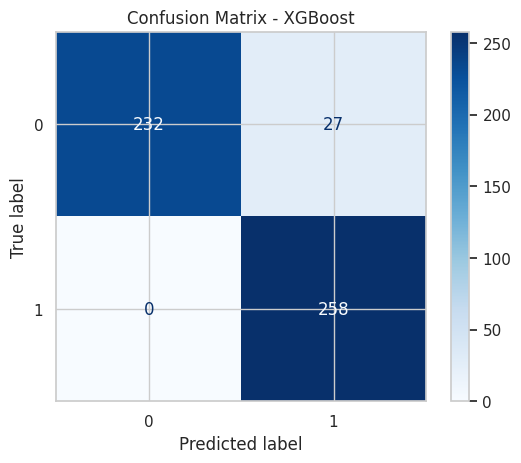

In [30]:
for model_name, (model, param_grid) in models.items():
    print(f"\nTraining dan tuning untuk {model_name}...")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"Best params {model_name}: {grid.best_params_}")
    best_models[model_name] = grid.best_estimator_

    y_pred = grid.predict(X_test)
    print(f"Classification report {model_name}:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

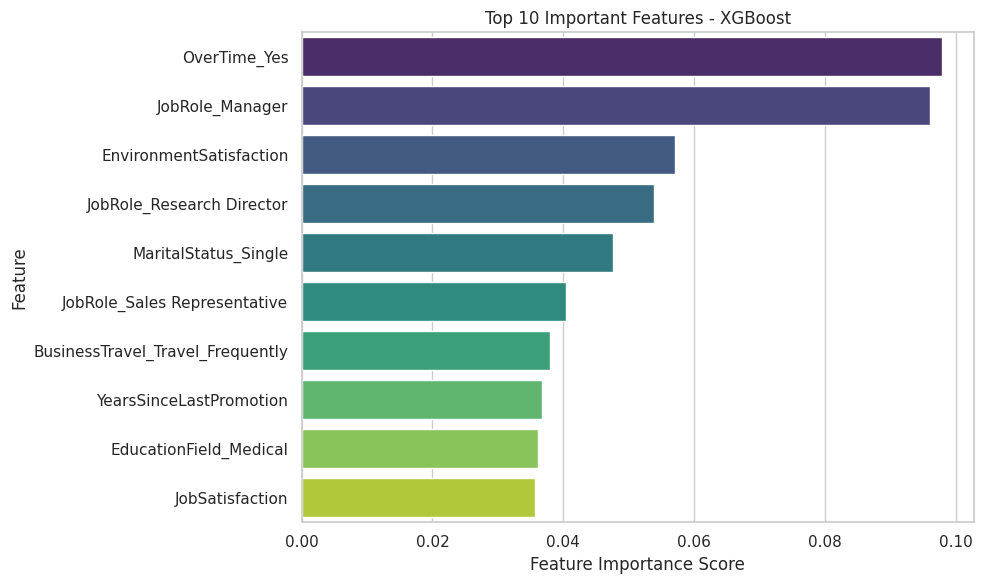

XGBoost Model Results:
Accuracy: 0.9478
ROC AUC: 0.9885

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       259
           1       0.91      1.00      0.95       258

    accuracy                           0.95       517
   macro avg       0.95      0.95      0.95       517
weighted avg       0.95      0.95      0.95       517



In [31]:
model_xg = best_models['XGBoost']

importances = model_xg.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis',
            hue='Feature', legend=False)
plt.title(f'Top {top_n} Important Features - XGBoost')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

y_prob = model_xg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"XGBoost Model Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [32]:
top_10_features = feature_importance_df.head(10)
csv_file_path = 'top_10_important_features.csv'
top_10_features.to_csv(csv_file_path, index=False)
print(f"\nTop 10 fitur penting telah disimpan ke: {csv_file_path}")


Top 10 fitur penting telah disimpan ke: top_10_important_features.csv


### Save Model

In [33]:
model_xg = best_models['XGBoost']
joblib.dump(model_xg, 'xgboost_model.pkl')
print("Model XGBoost telah disimpan sebagai 'xgboost_model.pkl'")

Model XGBoost telah disimpan sebagai 'xgboost_model.pkl'


### Test Model

In [35]:
predict_df = selected_features_df[selected_features_df['Attrition'] != 1]
predict_df = df.loc[predict_df.index, ['EmployeeId']].join(predict_df)

In [36]:
def predict_and_save(predict_df):
    model = joblib.load("xgboost_model.pkl")

    encoded_columns = joblib.load("encoded_columns.pkl")

    if 'Attrition' in predict_df.columns:
        actual_attrition = predict_df['Attrition'].copy()
        df_input = predict_df.drop(columns=['Attrition'])
    else:
        actual_attrition = None
        df_input = predict_df.copy()

    important_categorical = ['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']

    important_numerical = [
        'MonthlyIncome',
        'TotalWorkingYears',
        'YearsAtCompany',
        'YearsWithCurrManager',
        'Age',
        'JobSatisfaction',
        'EnvironmentSatisfaction',
        'NumCompaniesWorked',
        'YearsSinceLastPromotion'
    ]

    X = df_input[important_categorical + important_numerical]
    X_encoded = pd.get_dummies(X, columns=important_categorical, drop_first=True)

    for col in encoded_columns:
        if col not in X_encoded.columns:
            X_encoded[col] = 0

    X_encoded = X_encoded[encoded_columns]

    y_pred = model.predict(X_encoded)
    y_proba = model.predict_proba(X_encoded)

    result_df = predict_df.copy()
    result_df['Attrition (Actual)'] = actual_attrition if actual_attrition is not None else "-"
    result_df['PredictedAttrition'] = y_pred
    result_df['Probability'] = [round(p[1], 4) for p in y_proba]

    result_df.to_csv("hasil_prediksi.csv", index=False)
    print("Hasil prediksi disimpan ke 'hasil_prediksi.csv'")

    idx = 3
    print("\nHasil Prediksi Baris ke-3:")
    print(result_df.iloc[idx][['PredictedAttrition', 'Probability']])

    return result_df

In [37]:
hasil = predict_and_save(predict_df)

Hasil prediksi disimpan ke 'hasil_prediksi.csv'

Hasil Prediksi Baris ke-3:
PredictedAttrition        0
Probability           0.252
Name: 5, dtype: object


In [38]:
pd.read_csv('hasil_prediksi.csv')

,EmployeeId,BusinessTravel,EducationField,JobRole,MaritalStatus,OverTime,MonthlyIncome,TotalWorkingYears,YearsAtCompany,YearsWithCurrManager,Age,JobSatisfaction,EnvironmentSatisfaction,NumCompaniesWorked,YearsSinceLastPromotion,Attrition,Attrition (Actual),PredictedAttrition,Probability
0,1,Travel_Frequently,Other,Human Resources,Married,Yes,2991,7,6,2,38,2,4,0,1,0,0,0,0.0166
1,4,Travel_Frequently,Marketing,Sales Executive,Married,No,13525,23,20,8,42,2,3,5,4,0,0,0,0.4317
2,5,Travel_Rarely,Medical,Research Scientist,Married,No,2001,20,5,2,40,3,3,2,0,0,0,0,0.0735
3,6,Travel_Rarely,Medical,Human Resources,Married,No,2804,1,1,0,29,2,4,1,0,0,0,0,0.2520
4,7,Travel_Rarely,Medical,Sales Executive,Married,Yes,7457,6,4,2,40,4,2,2,0,0,0,0,0.1341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,1463,Travel_Rarely,Life Sciences,Sales Executive,Single,Yes,7082,21,2,2,41,3,4,3,0,0,0,1,0.7826
1287,1464,Travel_Rarely,Medical,Sales Executive,Single,No,8381,18,14,10,53,1,4,7,8,0,0,0,0.3373
1288,1466,Travel_Rarely,Life Sciences,Manufacturing Director,Single,Yes,7861,10,1,0,38,3,3,4,0,0,0,0,0.4718
1289,1467,Travel_Rarely,Life Sciences,Research Director,Divorced,No,13269,19,14,11,50,1,4,5,1,0,0,0,0.0097


In [ ]:
!pip freeze > requirements.txt